In [1]:
import pandas as pd
import numpy as np
import pickle
from cvxopt import matrix, solvers

In [2]:
import warnings

# Suppress all FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
data_folder = '/Users/Desktop/Quant Asset/' 
with open(data_folder + 'hw2_solution-2.pickle', 'rb') as file:
    data = pickle.load(file)

In [40]:
# Ensure the 'date' column is in datetime format
isactive = data['isactive'].copy()
isactive = isactive.reset_index()

isactive['date '] = pd.to_datetime(isactive['date '])
isactive = isactive.rename(columns={'date ': 'date'})

month_begin = isactive.groupby([isactive['date'].dt.year, isactive['date'].dt.month]).head(1)

match_index = month_begin.index

In [41]:
adjusted_indices = [match_index[0]]
for idx in match_index[1:]:
    if month_begin.loc[idx, 'date'].day != 1:
        adjusted_idx = idx - 1
        adjusted_indices.append(adjusted_idx)
    else:
        adjusted_indices.append(idx)

print("Original indices:", match_index.tolist())
print("Adjusted indices:", adjusted_indices)

Original indices: [0, 13, 36, 58, 79, 102, 122, 143, 165, 188, 208, 231, 253, 274, 297, 318, 340, 363, 383, 405, 427, 448, 470, 493, 514, 536, 558, 579, 602, 623, 643, 666, 688, 709, 731, 753, 775, 797, 818, 840, 863, 884, 904, 927, 948, 970, 992, 1013, 1036, 1058, 1079, 1101, 1123, 1145, 1165, 1188, 1208, 1231, 1253, 1274, 1297, 1318, 1340, 1362, 1383, 1406, 1427, 1448, 1470, 1493, 1513, 1536, 1558]
Adjusted indices: [0, 13, 36, 57, 79, 102, 122, 143, 165, 187, 208, 231, 252, 274, 297, 317, 340, 362, 382, 405, 427, 448, 470, 492, 514, 536, 557, 579, 602, 623, 643, 666, 687, 709, 731, 752, 775, 797, 818, 840, 862, 884, 904, 927, 947, 970, 992, 1013, 1036, 1057, 1079, 1101, 1122, 1145, 1165, 1187, 1208, 1231, 1252, 1274, 1297, 1317, 1340, 1362, 1383, 1406, 1427, 1448, 1470, 1492, 1513, 1536, 1557]


In [42]:
active_index = adjusted_indices[-60:]
past_1yr_index = adjusted_indices[:-12]

In [43]:
return_matrix = data['tri'].pct_change() 
return_matrix.backfill(axis=0, inplace=True)

In [44]:
lag_return = {}
sigma = {}
t = {}
for i in np.arange(len(active_index)):
    active_stock = isactive.iloc[active_index[i]]
    ret = return_matrix.iloc[past_1yr_index[i]:active_index[i]+1]
    ret_matrix = ret.values * (active_stock[1:].values)
    lag_return[active_stock[0]] = ret_matrix.mean(axis=0)
    sigma[active_stock[0]] = ret_matrix.var(axis=0)
    t[active_stock[0]] = len(ret_matrix)
    

In [45]:
avg_return = pd.DataFrame(lag_return).T
avg_return.columns = return_matrix.columns

sigma_matrix = pd.DataFrame(sigma).T
sigma_matrix.columns = return_matrix.columns

t_matrix = pd.DataFrame(t,index=[0]).T

In [46]:
omegahat = np.sqrt(np.mean(sigma_matrix, axis = 1).astype(float))

deltahat = np.sqrt(np.var(avg_return, axis = 1).astype(float) - omegahat**2 / t_matrix.iloc[:,0].astype(float))
deltahat = deltahat.fillna(0)

shrink = deltahat**2 / (deltahat**2 + omegahat**2 / t_matrix.iloc[:,0].astype(float))
shrink

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


2019-10-01    0.991052
2019-11-01    0.990988
2019-11-29    0.990967
2020-01-01    0.990168
2020-01-31    0.991454
2020-02-28    0.991059
2020-04-01    0.986373
2020-05-01    0.986588
2020-06-01    0.985533
2020-07-01    0.981806
2020-07-31    0.982859
2020-09-01    0.980789
2020-10-01    0.979248
2020-10-30    0.973911
2020-12-01    0.976879
2021-01-01    0.977339
2021-02-01    0.971096
2021-03-01    0.973595
2021-04-01    0.973434
2021-04-30    0.980335
2021-06-01    0.981375
2021-07-01    0.982602
2021-07-30    0.985348
2021-09-01    0.987317
2021-10-01    0.983597
2021-11-01    0.983603
2021-12-01    0.981531
2021-12-31    0.981724
2022-02-01    0.977824
2022-03-01    0.978116
2022-04-01    0.969899
2022-04-29    0.964377
2022-06-01    0.955598
2022-07-01    0.945107
2022-08-01    0.869054
2022-09-01    0.917922
2022-09-30    0.900076
2022-11-01    0.879953
2022-12-01    0.866966
2022-12-30    0.866817
2023-02-01    0.864499
2023-03-01    0.859477
2023-03-31    0.859807
2023-05-01 

In [47]:
# alpha 1
j1 = np.linspace(0,21,22)
weights1 = 1/11 - 1/231 * j1

alpha1 = -return_matrix.rolling(window=22).apply(lambda x: np.dot(x, weights1), raw=True)
alpha1 = alpha1.fillna(0)
demeaned_alpha1 = alpha1.sub(alpha1.mean(axis=1), axis=0)
std_alpha1 = demeaned_alpha1.div(demeaned_alpha1.std(axis=1), axis=0)
alpharev = std_alpha1.clip(lower=-3, upper=3)
alpharev

,289504,755087,929303,74517L,8917JF,89258K,143451,950997,31270N,30939T,...,68066N,77161H,779102,9215N3,992809,94405Z,32993L,772868,143406,142423
date,,,,,,,,,,,,,,,,,,,,,
2018-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-06,0.788542,0.043637,-1.121756,0.536256,0.222620,0.734615,-0.040770,-0.301781,-0.401478,0.561064,...,-0.468316,-1.590363,-0.704904,-0.497061,-0.641091,0.193397,-0.770313,-0.207871,-0.342635,0.352302
2024-09-09,0.843967,-0.079948,-1.068665,0.547495,0.331769,0.936704,-0.210485,-0.332073,-0.103412,-0.006513,...,-0.441640,-1.545263,-0.407215,-0.430051,-0.742242,0.283218,-0.635624,-0.175507,-0.160369,0.265878
2024-09-10,0.602856,-0.102758,-0.968959,0.432356,1.239631,0.978640,0.162056,-0.364056,-0.044937,-0.863756,...,-0.313271,-1.551777,-0.319237,-0.446282,-0.889727,0.353384,-0.549464,-0.198872,-0.357227,0.123106


In [48]:
# alpha 2
rec = data['rec'].copy()
j2 = np.linspace(0,45,46)
weights2 = 1/23 - 1/1035 * j2

alpha2 = rec.rolling(window=46).apply(lambda x: np.dot(x, weights2), raw=True)
alpha2 = alpha2.fillna(0)
demeaned_alpha2 = alpha2.sub(alpha2.mean(axis=1), axis=0)
std_alpha2 = demeaned_alpha2.div(demeaned_alpha2.std(axis=1), axis=0)
alpharec = std_alpha2.clip(lower=-3, upper=3)
alpharec

,289504,755087,929303,74517L,8917JF,89258K,143451,950997,31270N,30939T,...,779102,9215N3,992809,94405Z,32993L,772868,143406,142423,756206,932911
2018-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-06,0.492763,-0.320004,0.574040,-0.320004,3.0,-0.320004,-0.320004,-0.320004,0.574040,-0.320004,...,1.305530,0.655316,2.321488,-0.320004,-0.320004,-0.320004,0.452125,1.021061,-0.320004,-0.320004
2024-09-09,0.517968,-0.321551,0.597922,-0.321551,3.0,-0.321551,-0.321551,-0.321551,0.597922,-0.321551,...,1.317510,0.677876,2.356914,-0.321551,-0.321551,-0.321551,0.477991,1.037670,-0.321551,-0.321551
2024-09-10,0.577619,-0.303625,0.657732,-0.303625,3.0,-0.303625,-0.303625,-0.303625,0.657732,-0.303625,...,1.378749,0.737845,2.460275,-0.303625,-0.303625,-0.303625,0.537562,1.098354,-0.303625,-0.303625
2024-09-11,0.641055,-0.305032,0.723324,-0.305032,3.0,-0.305032,-0.305032,-0.305032,0.723324,-0.305032,...,1.463740,0.805592,2.615499,-0.305032,-0.305032,-0.305032,0.599921,1.175801,-0.305032,-0.305032


In [49]:
# alpha 3
mtbv = data['mtbv'].copy()
mtbv.replace("$$ER: 2376,NO DATA AVAILABLE", 0, inplace=True)
mtbv = mtbv.fillna(0)
prc = data['price'].copy()
prc = prc.fillna(0)

alpha3 = mtbv.astype(float) / prc.astype(float)
alpha3 = alpha3.fillna(0)
#alpha3 = alpha3.fillna(0)
demeaned_alpha3 = alpha3.sub(alpha3.mean(axis=1), axis=0)
std_alpha3 = demeaned_alpha3.div(demeaned_alpha3.std(axis=1), axis=0)
alphaval = std_alpha3.clip(lower=-3, upper=3)
alphaval

,289504,755087,929303,74517L,8917JF,89258K,143451,950997,31270N,30939T,...,68066N,77161H,779102,9215N3,992809,94405Z,32993L,772868,143406,142423
date,,,,,,,,,,,,,,,,,,,,,
2018-09-12,-0.149098,-0.177203,-0.149494,-0.143411,-0.105666,0.219272,-0.176951,-0.094294,-0.082619,-0.131578,...,-0.139006,-0.173268,-0.148751,-0.085263,-0.068440,-0.192403,-0.172883,0.011055,-0.152444,-0.117921
2018-09-13,-0.149030,-0.177230,-0.149535,-0.143426,-0.105741,0.218512,-0.176933,-0.094445,-0.082175,-0.131606,...,-0.139168,-0.173295,-0.148726,-0.085332,-0.068442,-0.192399,-0.172870,0.011062,-0.152466,-0.117933
2018-09-14,-0.149148,-0.177221,-0.149513,-0.143434,-0.105669,0.218436,-0.176925,-0.094270,-0.082151,-0.131539,...,-0.139088,-0.173369,-0.148757,-0.085592,-0.068415,-0.192393,-0.172873,0.011019,-0.152466,-0.117932
2018-09-17,-0.149091,-0.177313,-0.149590,-0.143356,-0.105649,0.219022,-0.177061,-0.094485,-0.082600,-0.128065,...,-0.139035,-0.173465,-0.148668,-0.085925,-0.068506,-0.192457,-0.172932,0.011133,-0.152521,-0.117953
2018-09-18,-0.149132,-0.177231,-0.149590,-0.143413,-0.105631,0.218949,-0.177024,-0.094470,-0.082455,-0.128056,...,-0.139053,-0.173304,-0.148747,-0.085701,-0.068442,-0.192416,-0.172903,0.010837,-0.152481,-0.117925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-06,-0.205021,-0.273297,-0.209190,-0.227590,-0.243697,0.328588,-0.261556,-0.133658,-0.005345,-0.219837,...,-0.188603,-0.237391,-0.200942,-0.143188,-0.208778,-0.203505,-0.259866,-0.034001,-0.218190,-0.173234
2024-09-09,-0.205219,-0.273379,-0.208613,-0.226785,-0.243622,0.322136,-0.261329,-0.133996,-0.004891,-0.220101,...,-0.188997,-0.237341,-0.200698,-0.143429,-0.208806,-0.203464,-0.259848,-0.034342,-0.218217,-0.173293
2024-09-10,-0.204674,-0.273046,-0.208397,-0.227027,-0.243425,0.327451,-0.261087,-0.133276,-0.004317,-0.219196,...,-0.188693,-0.237019,-0.200571,-0.142344,-0.208519,-0.203377,-0.259612,-0.033955,-0.217929,-0.172947


In [50]:
# alpha 4 
alpha4 = return_matrix.astype(float).shift(2).rolling(window=11).mean()
demeaned_alpha4 = alpha4.sub(alpha4.mean(axis=1), axis=0)
std_alpha4 = demeaned_alpha4.div(demeaned_alpha4.std(axis=1), axis=0)
alphamom = std_alpha4.clip(lower=-3, upper=3)
alphamom

,289504,755087,929303,74517L,8917JF,89258K,143451,950997,31270N,30939T,...,68066N,77161H,779102,9215N3,992809,94405Z,32993L,772868,143406,142423
date,,,,,,,,,,,,,,,,,,,,,
2018-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-06,0.792759,1.171415,1.147684,-1.041055,-0.151875,0.275221,0.362704,1.607018,0.410301,3.000000,...,-0.990549,1.296385,-1.365519,-0.631097,0.711092,-0.388547,-1.608958,-1.302979,0.693747,0.504209
2024-09-09,0.935666,1.079382,1.197877,-1.374735,0.584345,-0.164783,1.008080,1.276283,0.721266,2.243458,...,-0.709627,1.287128,-1.673555,-0.632903,0.392229,-0.015954,-1.350130,-1.277914,1.035578,-0.095042
2024-09-10,0.782183,1.028127,1.039121,-1.468699,0.917183,-0.119519,1.462620,1.246789,0.998381,2.322619,...,-0.831186,0.257560,-1.985781,-0.900667,0.090866,-0.019647,-1.479401,-1.210829,0.777715,-0.284468


In [51]:
alphablend = 0.5 * alpharev + 0.25 * alpharec + 0.15 * alphaval + 0.1 * alphamom
alphablend = alphablend.sub(alphablend.mean(axis=1), axis=0)
alphablend = alphablend.div(alphablend.std(axis=1), axis=0)
alphablend = alphablend.clip(lower=-3, upper=3)
alphablend

,13454U,142423,142440,142572,142836,143191,143198,143238,143267,143328,...,993597,997371,997836,997863,997966,998054,998064,998075,998080,998500
date,,,,,,,,,,,,,,,,,,,,,
2018-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-06,-1.343877,0.993294,1.204656,2.103049,-2.352860,-0.712185,0.242127,0.895357,1.214550,-0.815878,...,0.053584,1.676795,0.339033,1.430227,0.027768,-0.347235,-0.002986,-0.803461,-0.155991,0.147114
2024-09-09,-1.419135,0.778887,1.119220,1.967484,-2.251460,-0.809711,0.084727,0.957847,1.316649,-0.853486,...,-0.035852,1.910600,-0.341976,0.970860,0.292740,-0.245087,0.550862,-0.920888,-0.171686,0.337964
2024-09-10,-1.522272,0.628398,1.206318,1.983705,-2.200307,-0.711972,-0.182608,0.707310,0.826684,-0.853934,...,-0.018683,1.387460,-0.205832,1.275044,0.598445,-0.309133,0.792692,-0.888734,-1.098702,0.427657


In [52]:
alldata = pd.read_pickle(data_folder + 'alldata.pkl')
index_country_map = {
    'BEL20': 'Belgium',
    'OMX20': 'Denmark',
    'HEX25': 'Finland',
    'SBF120': 'France',
    'DAX': 'Germany',
    'AEX25': 'Holland',
    'AMX25': 'Holland',
    'OBX25': 'Norway',
    'OMX30': 'Sweden',
    'SMI20': 'Switzerland'
}

# Convert the data into a DataFrame
country = pd.DataFrame(alldata[5]).drop_duplicates(subset=['dscode'], keep='first')

# Map the 'index' column to the corresponding country
country['country'] = country['index'].map(index_country_map)

country_matrix = pd.crosstab(country['dscode'], country['country'])
f = int(100e6 / country_matrix.columns.size)

country_matrix.index = country_matrix.index.astype(str)
country_matrix = country_matrix[~country_matrix.index.duplicated(keep='first')]
country_matrix = country_matrix[country_matrix.index.isin(return_matrix.columns)]
country_matrix = country_matrix.reindex(return_matrix.columns)
country_matrix

country,Belgium,Denmark,Finland,France,Germany,Holland,Norway,Sweden,Switzerland
289504,1,0,0,0,0,0,0,0,0
755087,1,0,0,0,0,0,0,0,0
929303,1,0,0,0,0,0,0,0,0
74517L,1,0,0,0,0,0,0,0,0
8917JF,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
94405Z,0,0,0,0,0,0,0,0,1
32993L,0,0,0,0,0,0,0,0,1
772868,0,0,0,0,0,0,0,0,1
143406,0,0,0,0,0,0,0,0,1


In [53]:
industry = pd.DataFrame(alldata[3]).iloc[:,:-1].drop_duplicates(subset=['dscode'], keep='first')
industry_matrix = pd.crosstab(industry['dscode'], industry['industry'])

#r = int(100e6 / industry_matrix.columns.size)
r = 300_000

industry_matrix.index = industry_matrix.index.astype(str)
industry_matrix = industry_matrix[~industry_matrix.index.duplicated(keep='first')]
industry_matrix = industry_matrix[industry_matrix.index.isin(return_matrix.columns)]
industry_matrix = industry_matrix.reindex(return_matrix.columns)
industry_matrix

industry,AERSP,ALTEN,AUTMB,BANKS,BEVES,CHMCL,CNSTM,CNSVS,ELECT,ELTNC,...,RLISV,RTAIL,SFTCS,SUPSV,TECHD,TELEQ,TELSP,TOBAC,TRLES,WASTE
289504,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
755087,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
929303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74517L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8917JF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94405Z,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32993L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
772868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
143406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
import statsmodels.api as sm

# Assuming `return_matrix` is a DataFrame of shape (T, N) where T is number of days and N is number of stocks
# Each cell return_matrix[t, n] is the return of stock n on day t

# Calculate the equal-weighted market return for each day
market_return_matrix = return_matrix.mean(axis=1)

# Create an empty dataframe to store beta values (T x N)
beta_matrix = pd.DataFrame(index=return_matrix.index, columns=return_matrix.columns)

# Define the rolling window size (21 days)
window_size = 21

# Perform regression for each stock on each day (starting from day 22)
for day in range(window_size, len(return_matrix)):
    # Define the regression window (21 days before the current day)
    window_data = return_matrix.iloc[day - window_size:day]
    market_window = market_return_matrix.iloc[day - window_size:day]
    
    # Perform regression for each stock
    for stock in return_matrix.columns:
        stock_return_matrix = window_data[stock]
        
        # Regression: Y = market return, X = stock return
        X = sm.add_constant(market_window)  # Add constant for intercept
        Y = stock_return_matrix
        
        # Run OLS regression
        model = sm.OLS(Y, X).fit()
        
        # Store the beta (coefficient of the market return)
        beta_matrix.loc[return_matrix.index[day], stock] = model.params[0]

# The `beta_matrix` now contains the beta values for each stock on each day

In [55]:
data

{'price':             289504  755087  929303  74517L    8917JF  89258K  143451  950997  \
 date                                                                           
 2018-09-12   75.75   150.5   44.26   37.59   76.8000  13.560  110.80   51.18   
 2018-09-13   76.30   150.8   43.97   37.31   77.2000  13.620  110.70   51.26   
 2018-09-14   76.53   150.8   43.96   37.62   81.8000  13.660  110.70   51.62   
 2018-09-17   76.66   151.1   43.98   37.81   81.4000  13.710  110.30   52.00   
 2018-09-18   77.45   153.5   44.01   39.05   81.4000  13.990  110.30   52.00   
 ...            ...     ...     ...     ...       ...     ...     ...     ...   
 2024-09-06   56.56   180.2   46.34   23.14  487.6001   2.545   65.90   47.46   
 2024-09-09   57.76   182.6   46.04   23.34  498.8999   2.520   66.45   47.76   
 2024-09-10   58.28   181.8   46.06   23.04  488.2000   2.500   67.40   46.84   
 2024-09-11   58.26   181.7   45.94   23.20  491.8000   2.500   66.70   44.56   
 2024-09-12   58.54

In [60]:
# Load necessary data into memory
tcost = data['tcost'].copy().fillna(0).astype(float)
volume = data['volume'].copy().astype(float)
capital = data['cap'].copy().astype(float)
num_country = country_matrix.shape[1]
num_industry = industry_matrix.shape[1]

# Define initial parameters
# time longer, lambda should be adjusted to be smaller
#    mu should be larger
lambda_ = 0.001
mu= 0.008
t0 = 46
epsilon = 1e-5
tol = 1e3
max_iter = 1

# Scaling for numerical stability
# scaling_factor = 1e3  # Reduced scaling factor

# Initialize position to zero
N = return_matrix.shape[1]
T = return_matrix.shape[0]

w_position = pd.DataFrame(index = return_matrix.index, columns = return_matrix.columns)
y_matrix= pd.DataFrame(index = return_matrix.index, columns = return_matrix.columns)
z_matrix= pd.DataFrame(index = return_matrix.index, columns = return_matrix.columns)

target_turnover = 15e6
target_bs = 50e6 

# Maximum trade size (theta) expand rooling window for each day
ADV = volume.fillna(0).expanding().mean() * 1000

In [61]:
for iteration in range(max_iter):
    total_turnover = 0.0
    total_bs_long = 0.0
    total_bs_short = 0.0
    trade = pd.DataFrame(index = return_matrix.index, columns = return_matrix.columns)
    w = np.zeros(N)
    long_bs = 50_000_000

    for t in np.arange(t0, T):
        # Calculate the covariance matrix
        cov_t = return_matrix.iloc[1:t].cov()
        alpha_t = np.array(alphablend.iloc[t-1].fillna(0))
        tc_t = np.array(tcost.iloc[t-1].fillna(0))
        beta_t = np.array(beta_matrix.iloc[t].fillna(0))

        POS = np.minimum(ADV, 0.025 * long_bs)

        UB_array_1 = np.maximum(0,np.minimum(ADV.iloc[t-1,:].values.reshape(-1, 1) - w.reshape(-1, 1), POS.iloc[t-1,:].values.reshape(-1, 1)))
        UB_array_2 = np.maximum(0,np.minimum(ADV.iloc[t-1,:].values.reshape(-1, 1) + w.reshape(-1, 1) , POS.iloc[t-1,:].values.reshape(-1, 1)))
        LB = np.zeros((N*2, 1))
        UB = matrix(np.concatenate([UB_array_1, UB_array_2]))

        H = matrix(2 * mu * np.block([[cov_t, -cov_t],[-cov_t, cov_t]]) + epsilon * np.eye(2 * N))
        g = matrix(np.concatenate([2 * mu * cov_t @ w - alpha_t + lambda_ * tc_t, -2 * mu * cov_t @ w + alpha_t + lambda_ * tc_t]))

        # Equality constraint 1 over all weights
        C = np.zeros((1, 2 * N)) 
        C[0, :N] = beta_t
        C[0, N:] = -beta_t

        C = matrix(C)
        d = matrix(-beta_t @ w)

        # Construct A and b for inequality constraints
        A = matrix(np.block([[industry_matrix.T, -industry_matrix.T],[-industry_matrix.T, industry_matrix.T], 
                             [country_matrix.T, -country_matrix.T], [-country_matrix.T, country_matrix.T]]))

        # b = matrix(np.block([[r * np.ones((num_industry, 1)) - (industry_matrix.T @ w).reshape(-1,1)],[r * np.ones((num_industry, 1)) + industry_matrix.T @ w], 
                             #[f * np.ones((num_country, 1)) - country_matrix.T @ w], [f * np.ones((num_country, 1)) + country_matrix.T @ w]]))

        # Use np.concatenate to combine the constraints vertically
        b = matrix(np.concatenate([
            r * np.ones(num_industry) - industry_matrix.T @ w,
            r * np.ones(num_industry) + industry_matrix.T @ w,
            f * np.ones(num_country) - country_matrix.T @ w,
            f * np.ones(num_country) + country_matrix.T @ w
        ]))

        
        # G = matrix([A, np.eye(2*N), -np.eye(2*N)])
        identity = matrix(np.identity(len(g)))
        G = matrix([A, identity, -identity])

        h_combined = np.vstack([b, UB, -LB])
        h = matrix(h_combined)
        
        solvers.options['show_progress'] = False
        sol = solvers.qp(H, g, G, h, C, d)

        u = np.array(sol['x'])
        
        # Split into long and short weights
        y = u[:N].flatten() 
        z = u[N:].flatten() 

        w_position.iloc[t,:]=w
        y_matrix.iloc[t,:]=y
        z_matrix.iloc[t,:]=z
        
        w = w + y - z

        if t > t0:
            trade.iloc[t,:] = y + z
            long_bs = w[w > 0].sum()
            short_bs = w[w < 0].sum()
            total_bs_long += long_bs
            total_bs_short += short_bs
            total_turnover += np.sum(y + z)
        else:
            trade.iloc[t,:] = y + z
            long_bs = w[w > 0].sum()
            short_bs = w[w < 0].sum()
            total_bs_long += long_bs
            total_bs_short += short_bs
            total_turnover += 0

    # change denominator to time
    avg_turnover = total_turnover / (T-t0-1)
    avg_bs_long = total_bs_long / (T-t0)
    avg_bs_short = total_bs_short / (T-t0)
    
    # Print iteration information
    print(f"Iteration {iteration + 1}:")
    print(f"Average Turnover: €{avg_turnover:.2f}")
    print(f"Average Book Size (Long): €{avg_bs_long:.2f}")
    print(f"Average Book Size (Short): €{avg_bs_short:.2f}")

    # Convergence checks
    turnover_diff = abs(avg_turnover - target_turnover)
    book_size_diff_long = abs(avg_bs_long - target_bs)
    book_size_diff_short = abs(avg_bs_short - target_bs)

    # Final parameters
    print(f"Final Lambda: {lambda_}")
    print(f"Final Mu: {mu}")


Iteration 1:
Average Turnover: €7790021.87
Average Book Size (Long): €55322857.61
Average Book Size (Short): €-55542179.99
Final Lambda: 0.001
Final Mu: 0.008


In [26]:
back_weight = np.zeros((T, N))  # T x N matrix for stock positions in €
pnl = np.zeros(T)  # T x 1 array for cumulative P&L
booksize = np.zeros(T)  # T x 1 array for daily book size
tradesize = np.zeros(T)  # T x 1 array for daily trade size

In [27]:
w_copy = w_position.copy()
y_copy = y_matrix.copy()
z_copy = z_matrix.copy()

# 5)

In [28]:
for t in range(t0, T):  # Start from day 1, ignoring day 0
    # Update stock positions at the end of day t
    back_weight[t, :] = (
        w_position.iloc[t, :] * (1 + return_matrix.iloc[t, :]) + trade.iloc[t, :]
    )

    # Compute daily P&L
    pnl[t] = (
        np.sum(w_position.iloc[t, :] * (return_matrix.iloc[t, :]))  # P&L from returns
        - np.sum(np.abs(trade.iloc[t, :]) * tcost.iloc[t, :])  # Transaction costs
    )
    
cumulative_pnl = np.cumsum(pnl)
booksize=abs(w_position).sum(axis=1).values
tradesize= trade.sum(axis=1).values

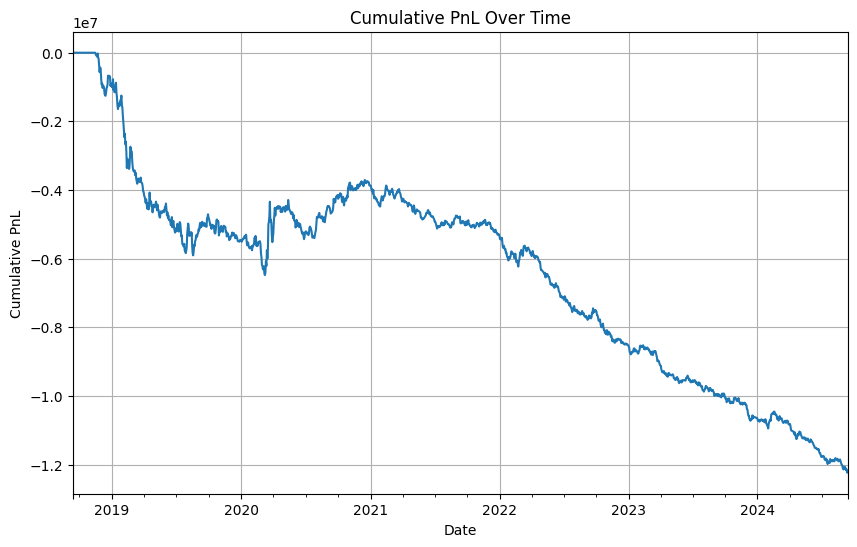

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pnl is already computed
# pnl is a NumPy array containing daily profit and loss

# Example pnl computation (replace this with your actual pnl)
dates = return_matrix.index
cumulative_pnl = np.cumsum(pnl)  # Calculate the cumulative PnL

# Convert cumulative PnL to a pandas Series for easy plotting
cumulative_pnl_series = pd.Series(data=cumulative_pnl, index=dates)

# Plot the cumulative PnL
plt.figure(figsize=(10, 6))
cumulative_pnl_series.plot()

# Adding plot labels and title
plt.title('Cumulative PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.grid(True)  # Add grid for better readability

# Show the plot
plt.show()


# 6)

In [30]:
# a)  Annualized Sharpe Ratio
trading_days = 252
pnl_pct_change = pd.Series(cumulative_pnl).pct_change()

# avoid Nan and inf in calculating mean
mean_daily_return = pnl_pct_change.iloc[47:].mean()
std_daily_return = pnl_pct_change.iloc[47:].std()

sharpe = (mean_daily_return / std_daily_return) * np.sqrt(trading_days)
print(f"Annualized Sharpe Ratio: {sharpe:.4f}")

Annualized Sharpe Ratio: 0.8536


In [31]:
# Create pandas Series for P&L and cumulative P&L
pnl_indexed = pd.Series(pnl, index=return_matrix.index)
cumulative_pnl_indexed = pd.Series(cumulative_pnl, index=return_matrix.index)

# Calculate high-water mark and drawdown periods
high_water_mark = cumulative_pnl_indexed.cummax()

# Variables for tracking the longest drawdown
longest_dd = 0
current_dd = 0
start_date = None
end_date = None
temp_start_date = None

# Track previous high-water mark
prev_high_water_mark = None

# Loop through the drawdown periods
for date, value in cumulative_pnl_indexed.items():
    if prev_high_water_mark is None or value > prev_high_water_mark:  # Strictly higher
        prev_high_water_mark = value
        if current_dd > longest_dd:
            longest_dd = current_dd
            start_date = temp_start_date
            end_date = date - pd.Timedelta(days=1)
        current_dd = 0
        temp_start_date = None
    else:  # Below high-water mark or equal to it
        if temp_start_date is None:  # Start of a new drawdown
            temp_start_date = date
        current_dd += 1

# Handle the case where the longest drawdown ends at the last date
if current_dd > longest_dd:
    longest_dd = current_dd
    start_date = temp_start_date
    end_date = cumulative_pnl_indexed.index[-1]

# Calculate the number of days (inclusive)
num_days = (end_date - start_date).days + 1  # Add 1 to include both start and end dates

# Output the result
print(f"Longest drawdown duration: {longest_dd} days")
print(f"Drawdown Start Date: {start_date}")
print(f"Drawdown End Date: {end_date}")
print(f"Number of days between {start_date} and {end_date}: {num_days} days")

Longest drawdown duration: 1566 days
Drawdown Start Date: 2018-09-13 00:00:00
Drawdown End Date: 2024-09-12 00:00:00
Number of days between 2018-09-13 00:00:00 and 2024-09-12 00:00:00: 2192 days


In [32]:
drawdown = cumulative_pnl_indexed - high_water_mark

# Find the deepest drawdown
deepest_dd = drawdown.min()

print(f"Deepest Drawdown: {deepest_dd:.2f} €")

Deepest Drawdown: -12238047.16 €


In [33]:
shrink = pd.DataFrame(shrink, columns = ["shrink"]).copy()
back_weight = pd.DataFrame(back_weight, columns = return_matrix.columns).copy()
pnl_final = pd.DataFrame(cumulative_pnl_indexed, columns = ["pnl"]).copy()
booksize_final = pd.DataFrame(booksize, index = return_matrix.index ,columns = ["booksize"]).copy()
tradesize_final = pd.DataFrame(tradesize, index = return_matrix.index ,columns = ["tradesize"]).copy()

In [34]:
# output into pickle file
data={'shrink':shrink,
      'alpharev':alpharev,
      'alpharec':alpharec,
      'alphaval':alphaval,
      'alphamom':alphamom,
      'alphablend':alphablend,
      'lambda':np.array([[lambda_]]),
      'mu':np.array([[mu]]),
      't0':np.array([[t0]]),
      'trade':trade,
      'back_weight':back_weight,
      'pnl':pnl_final,
      'booksize':booksize_final,
      'tradesize':tradesize_final,
      'sharpe':np.array([[sharpe]]),
      'longest_dd':np.array([[longest_dd]]),
      'deepest_dd':np.array([[deepest_dd]])}

with open('hw3_output.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)